In [5]:
import os
from tempfile import tempdir
from termios import TOSTOP
from time import time
from turtle import color
from unittest.mock import NonCallableMagicMock
import pandas as pd
import numpy as np
import warnings
import math
import re

import seaborn as sns
warnings.filterwarnings("ignore")

import sys
sys.path.append("./")

from pathlib import Path

import tqdm
import importlib

import matplotlib.pyplot as plt
# from PySide2.QtWidgets import QFileDialog, QApplication
# from PySide2.QtCore import Qt
from copy import copy 


In [1]:

from corems.mass_spectra.input import rawFileReader
from corems.molecular_id.factory.classification import HeteroatomsClassification, Labels
from corems.molecular_id.search.priorityAssignment import OxygenPriorityAssignment
from corems.molecular_id.search.molecularFormulaSearch import SearchMolecularFormulas
from corems.encapsulation.factory.parameters import MSParameters
from corems.encapsulation.constant import Atoms
from corems.mass_spectrum.calc.Calibration import MzDomainCalibration

import importlib
import corems.lc_icpms_ftms.calc.lc_icrms_qc_assign as icrms

importlib.reload(icrms)


<module 'corems.lc_icpms_ftms.calc.lc_icrms_qc_assign' from '/Users/christiandewey/CoreMS/corems/lc_icpms_ftms/calc/lc_icrms_qc_assign.py'>

In [84]:

def getParser(file):
    parser = rawFileReader.ImportMassSpectraThermoMSFileReader(file)
    return parser

def assign_formula(parser, interval, timerange, refmasslist=None):
    #Function to build formula assignment lists
    #Retrieve TIC for MS1 scans over the time range between 'timestart' and 'timestop' 

    tic=parser.get_tic(ms_type='MS')[0]
    tic_df=pd.DataFrame({'time': tic.time,'scan': tic.scans})

    times=list(range(timerange[0],timerange[1],interval))

    results=[]
    
    for timestart in times:

        scans=tic_df[tic_df.time.between(timestart,timestart+interval)].scan.tolist()

        mass_spectrum = parser.get_average_mass_spectrum_by_scanlist(scans)    
        mass_spectrum.molecular_search_settings.ion_charge = 1

        ppp = mass_spectrum.polarity
        print('polarity: %s' %ppp)
        #mass_spectrum.mass_spectrum.settings.calib_sn_threshold
        #mass_spectrum.mass_spectrum.settings.calib_pol_order
        #mass_spectrum.recalibrate_mass_spectrum(mass_spectrum, imzmeas, mzrefs, order=2)
        #MzDomainCalibration(mass_spectrum, ref_file_location).run()

        if refmasslist:
            mass_spectrum.settings.min_calib_ppm_error = 10
            mass_spectrum.settings.max_calib_ppm_error = -10
            calfn = MzDomainCalibration(mass_spectrum, refmasslist)
            ref_mass_list_fmt = calfn.load_ref_mass_list(refmasslist)

            imzmeas, mzrefs = calfn.find_calibration_points(mass_spectrum, ref_mass_list_fmt,
                                                        calib_ppm_error_threshold=(0, 2.0),
                                                        calib_snr_threshold=3)

            calfn.recalibrate_mass_spectrum(mass_spectrum, imzmeas, mzrefs, order=2)


        SearchMolecularFormulas(mass_spectrum, first_hit=False).run_worker_mass_spectrum()

        mass_spectrum.percentile_assigned(report_error=True)

        assignments=mass_spectrum.to_dataframe()

        assignments['Time']=timestart

        results.append(assignments)
    
    results=pd.concat(results,ignore_index=True)

    return(results)    

def plot_ms(df1, start_mz, end_mz, tstart, df2=None,df3=None, assignment= None, ax_ms=None, lbls=None, norm=False, labs=False, colors=None):   
    if ax_ms == None:
        f, ax = plt.subplots()
    
    else:
        ax = ax_ms

    if colors is not None:
        cols = colors
    else:
        cols = ['C0', 'C1', 'C2']
    mzrange= end_mz - start_mz
    ms_t_int=df1[df1['Time'] == tstart]
    ms_df = ms_t_int[((ms_t_int['Calibrated m/z']-start_mz)<mzrange) & ((ms_t_int['Calibrated m/z']-start_mz)>0)]

    maxdf1 = max(ms_df['S/N'])

    if norm:
        ms_df['S/N Norm'] = ms_df['S/N'] / maxdf1
    else:
        ms_df['S/N Norm'] = ms_df['S/N'] 

    

    print(ms_df['S/N Norm'])

    if lbls is not None:
        labels = lbls
    else:
        lbls = [None, None, None]

 
    _, stemlines1, _ =ax.stem('Calibrated m/z','S/N Norm',data=ms_df,  markerfmt=' ', basefmt=' ', linefmt=cols[0], label = labels[0])
    
    if df2 is not None:
        ms_t_int2=df2[df2['Time'] == tstart]
        ms_df2 = ms_t_int2[(abs(ms_t_int2['Calibrated m/z']-start_mz)<mzrange)& ((ms_t_int2['Calibrated m/z']-start_mz)>0)]

        maxdf2 = max(ms_df2['S/N'])

        if norm:
            ms_df2['S/N Norm'] = ms_df2['S/N'] / maxdf2
        else:
            ms_df2['S/N Norm'] = ms_df2['S/N'] 
        
        _, stemlines2, _ =ax.stem('Calibrated m/z','S/N Norm',data=ms_df2,  markerfmt=' ', basefmt=' ', linefmt=cols[1], label = labels[1])

    if df3 is not None:
        ms_t_int3=df3[df3['Time'] == tstart]
        ms_df3 = ms_t_int3[(abs(ms_t_int3['Calibrated m/z']-start_mz)<mzrange)& ((ms_t_int3['Calibrated m/z']-start_mz)>0)]

        maxdf3 = max(ms_df3['S/N'])

        if norm:
            ms_df3['S/N Norm'] = ms_df3['S/N'] / maxdf3
        else:
            ms_df3['S/N Norm'] = ms_df3['S/N'] 
        
        _, stemlines3, _ =ax.stem('Calibrated m/z','S/N Norm',data=ms_df3,  markerfmt=' ', basefmt=' ', linefmt=cols[2], label = labels[2])
    
    if df3 is not None:
        ax.set_ylim(0, max([maxdf1, maxdf2, maxdf3]) * 1.1)
    elif df2 is not None:
        ax.set_ylim(0, max([maxdf1, maxdf2]) * 1.1)
    else: 
        ax.set_ylim(0, maxdf1 * 1.1)

    ax.set_xlim(left = start_mz - mzrange*0.1, right = start_mz + mzrange + mzrange*0.1) 

    if labs:
        for mzr,peakr,mf,er in zip(ms_df['Calibrated m/z'], ms_df['S/N Norm'], ms_df['Molecular Formula'],  ms_df['m/z Error (ppm)']):

            #if (mzr- target_mz)  == 0:
            #    mz_text = ' m/z\n%.4f' % (mzr)
            #else:
            #    mz_text = r'$\Delta$' + ' m/z\n%.4f' % (mzr- target_mz)

            mz_text = 'm/z %.4f\n%s\n%.3f ppm' % (mzr,mf,er)
            ax.text(mzr, peakr + 0.02 *max(ms_df['S/N Norm']), mz_text, ha = 'center', fontsize = 'xx-small', weight = 'bold', color=cols[0])

        if df2 is not None:

            for mzr,peakr,mf, er in zip(ms_df2['Calibrated m/z'], ms_df2['S/N Norm'], ms_df2['Molecular Formula'], ms_df2['m/z Error (ppm)']):

            #if (mzr- target_mz)  == 0:
            #    mz_text = ' m/z\n%.4f' % (mzr)
            #else:
            #    mz_text = r'$\Delta$' + ' m/z\n%.4f' % (mzr- target_mz)

                mz_text = 'm/z %.4f\n%s\n%.3f ppm' % (mzr,mf,er)
                ax.text(mzr, peakr + 0.02 *max(ms_df2['S/N Norm']), mz_text, ha = 'center', fontsize = 'xx-small', weight = 'bold', color = cols[1])

        if df3 is not None:

            for mzr,peakr,mf, er in zip(ms_df3['Calibrated m/z'], ms_df3['S/N Norm'], ms_df3['Molecular Formula'], ms_df3['m/z Error (ppm)']):

            #if (mzr- target_mz)  == 0:
            #    mz_text = ' m/z\n%.4f' % (mzr)
            #else:
            #    mz_text = r'$\Delta$' + ' m/z\n%.4f' % (mzr- target_mz)

                mz_text = 'm/z %.4f\n%s\n%.3f ppm' % (mzr,mf,er)
                ax.text(mzr, peakr + 0.02 *max(ms_df3['S/N Norm']), mz_text, ha = 'center', fontsize = 'xx-small', weight = 'bold', color = cols[2])

   # theor_mz=pattern.mdiff+result['mass']
   # theor_int=pattern.ratio*result['abundance']
   # ax.stem(theor_mz,theor_int, basefmt=' ',linefmt='gray')

   # for isotope in pattern.isotope[pattern.requirement=='Y']:
   #     ax.stem('mz','intense',data=result[isotope],  markerfmt=' ', basefmt=' ',linefmt='red')
    if ax == None:

        ax.legend(('other', 'target'),bbox_to_anchor=(1.05, 1.0), loc='upper left',frameon=False)

        if(assignment):

            mf = assignment[0]
            score = assignment[1]
            er = assignment[2]

            ax.text(1.05,0.7,mf,transform=ax.transAxes)
            ax.text(1.05,0.6,'Error (ppm) = %.3f ' %er ,transform=ax.transAxes)
            ax.text(1.05,0.5,'Score = %.3f' %score ,transform=ax.transAxes)

    if norm: 
        ax.set(xlabel='Calibrated m/z',ylabel='Normalized S/N')
    else: 
        ax.set(xlabel='Calibrated m/z',ylabel='S/N')
    #ax.set_title('%.2f' %timerange[0] + ' to %.2f' %timerange[1] +' min', fontsize = 'medium')
    ax.legend(bbox_to_anchor = (1.00, 0.5), frameon =False, loc = 'center left')
    ax.axhline(y=0.0, color='black')
    plt.setp(stemlines1,'color', cols[0], 'linewidth', 2)
    if df2 is not None:
        plt.setp(stemlines2, 'color', cols[1],'linewidth', 2)
    if df3 is not None:
        plt.setp(stemlines3, 'color', cols[2],'linewidth', 2)
    plt.tight_layout()
    if ax_ms == None:
        return ax


def filterMzRange(results, mz_range):

    mz_i = mz_range[0]
    mz_f = mz_range[1]

    sub = results[(results['m/z'] >= mz_i) & (results['m/z'] <= mz_f)]

    return sub


def pltMZerror(results, bins=50):
    ## assignment error distribution
    _, ax = plt.subplots()
    for mol_class in sorted(results['mol_class'].unique()):

        counts, bins = np.histogram(np.asarray(results[results['mol_class']==mol_class]['m/z Error (ppm)']),bins = bins)

        ax.plot(bins[:-1], counts, label = mol_class)

    ax.set_xlim(-0.5,0.5)
    ax.legend(frameon=False)
    ax.set_xlabel('m/z assignment error (ppm)')
    ax.set_ylabel('# assigned features')

    return ax

def pltMZerror_pts(results):
    ## assignment error distribution
    _, ax = plt.subplots()
    for mol_class in sorted(results['mol_class'].unique()):

        ax.scatter(results[results['mol_class']==mol_class]['Calibrated m/z'], results[results['mol_class']==mol_class]['m/z Error (ppm)'], label = mol_class)

    #ax.set_xlim(-0.5,0.5)
    ax.legend(frameon=False,bbox_to_anchor=(1.0, 0.5))
    ax.set_xlabel('calibrated m/z')
    ax.set_ylabel('assignment error (ppm)')

    return ax

def assignMolClass(resultsdf, mz_cutoff = 800, sn_lim = 3):

    filtered_results=resultsdf[(resultsdf['m/z']<mz_cutoff) & (resultsdf['S/N']>sn_lim)]

    filtered_results['N']=filtered_results['N'].fillna(0)
    filtered_results['O']=filtered_results['O'].fillna(0)
    filtered_results['S']=filtered_results['S'].fillna(0)
    filtered_results['P']=filtered_results['P'].fillna(0)
    #filtered_results['Na']=filtered_results['Na'].fillna(0)

    filtered_results['mol_class']='Unassigned'
    filtered_results['mol_class'][filtered_results['C']>0]='CHO'
    filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['N']>0.5)]='CHON'
    filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['S']>0.5)]='CHOS'
    filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['P']>0.5)]='CHOP'
    #filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Na']>0.5)]='CHONa'
    filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['S']>0.5) & (filtered_results['N']>0.5)]='CHONS'
    filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['P']>0.5) & (filtered_results['N']>0.5)]='CHONP'
    #filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['Na']>0.5) & (filtered_results['N']>0.5)]='CHONNa'
    #filtered_results['mol_class'][(filtered_results['C']>0) & (filtered_results['P']>0.5) & (filtered_results['Na']>0.5) & (filtered_results['N']>0.5)]='CHONPNa'


    results= filtered_results[filtered_results['mol_class'] != 'Unassigned'] #[filtered_results['Is Isotopologue']==0]
    results['O/C']=results['O']/results['C']
    results['H/C']=results['H']/results['C']
    results['N/C']=results['N']/results['C']

    return results


In [57]:
# 1: assign formula to full scan 
MSParameters.mass_spectrum.threshold_method = 'signal_noise'
MSParameters.mass_spectrum.s2n_threshold = 2
MSParameters.ms_peak.peak_min_prominence_percent = 0.001

MSParameters.molecular_search.error_method = 'None'
MSParameters.molecular_search.min_ppm_error = -0.3
MSParameters.molecular_search.max_ppm_error = 0.3

MSParameters.molecular_search.isProtonated = True
MSParameters.molecular_search.isRadical = False
MSParameters.molecular_search.isAdduct = False

MSParameters.molecular_search.score_method = "prob_score"
MSParameters.molecular_search.output_score_method = "prob_score"


MSParameters.molecular_search.url_database = None
MSParameters.molecular_search.min_dbe = -1
MSParameters.molecular_search.max_dbe = 20

MSParameters.molecular_search.usedAtoms['C'] = (1,50)
MSParameters.molecular_search.usedAtoms['H'] = (4,100)
MSParameters.molecular_search.usedAtoms['O'] = (1,20)
MSParameters.molecular_search.usedAtoms['N'] = (0,6)
MSParameters.molecular_search.usedAtoms['S'] = (0,1)
MSParameters.molecular_search.usedAtoms['P'] = (0,1)


In [58]:

data2='/Users/christiandewey/Library/CloudStorage/Box-Box/Boiteau Lab/Mass Spec Data/21T at NHMFL/2022-10 Nicole & Christian/Christian/spring/20221103_LBA_Boiteau_Zorbax3p5_spring_400_500.raw'
data1='/Users/christiandewey/Library/CloudStorage/Box-Box/Boiteau Lab/Mass Spec Data/21T at NHMFL/2022-10 Nicole & Christian/Christian/spring/20221103_LBA_Boiteau_Zorbax3p5_spring_fullmz.raw'
qh2o='/Users/christiandewey/Library/CloudStorage/Box-Box/Boiteau Lab/Mass Spec Data/21T at NHMFL/2022-10 Nicole & Christian/Christian/spring/20221103_LBA_Boiteau_Zorbax3p5_qh2o_400_500.raw'


refmasslist = '/Users/christiandewey/CoreMS/tests/tests_data/ftms/nom_pos.ref'

savedir = '/Users/christiandewey/Desktop/221107-CoreMS'

trange = [16,22]
interval = 6
parser1 = getParser(data1)  #fullmz
results1 = assign_formula(parser1,interval=interval,timerange=trange, refmasslist=refmasslist)



polarity: 1
MS Obj loaded - 6326 peaks found.
MS Obj loaded - 6326 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
274 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.025 ppm
minimize function performed 326 fn evals and 6 iterations
'runworker'  5115.69 ms


Loading molecular formula database: 251938it [00:12, 20287.59it/s]
Started molecular formula search for class {"N": 3, "S": 1, "P": 1, "O": 15}, (de)protonated : 100%|██████████| 300/300 [00:16<00:00, 17.65it/s]
Loading molecular formula database: 148382it [00:08, 17761.94it/s]
Started molecular formula search for class {"N": 6, "S": 1, "P": 1, "O": 20}, (de)protonated : 100%|██████████| 260/260 [00:08<00:00, 29.54it/s]


'run_molecular_formula'  51973.45 ms
5522 assigned peaks and 804 unassigned peaks, total  = 87.29 %, relative abundance = 95.93 %, RMS error (best candidate) (ppm) = 0.071


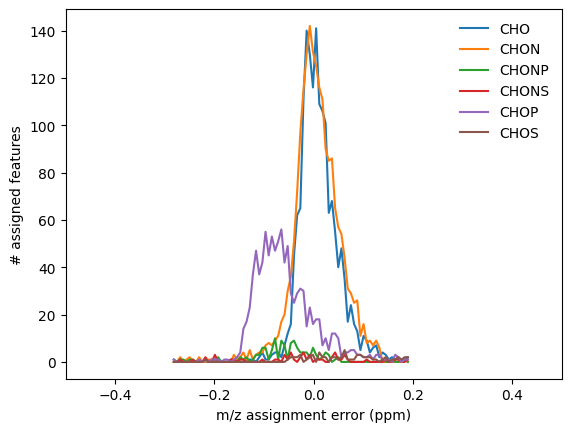

In [60]:
fresults1 = assignMolClass(results1)

pltMZerror(fresults1, bins=75)
plt.show()



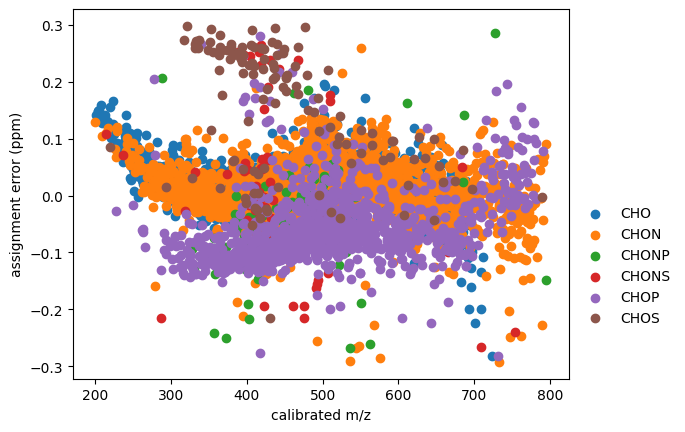

In [85]:
pltMZerror_pts(fresults1)

plt.show()

In [61]:
#trange = [12,14]
#interval = 2
parser2 = getParser(data2)  #400-500mz
results2 = assign_formula(parser2,interval=interval,timerange=trange, refmasslist=refmasslist)



polarity: 1
MS Obj loaded - 2775 peaks found.
MS Obj loaded - 2775 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
122 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.031 ppm
minimize function performed 370 fn evals and 7 iterations
'runworker'  5337.54 ms


Loading molecular formula database: 251938it [00:06, 36020.73it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "P": 1, "O": 15}, (de)protonated : 100%|██████████| 300/300 [00:05<00:00, 53.75it/s]
Loading molecular formula database: 148382it [00:03, 37490.46it/s] 
Started molecular formula search for class {"N": 6, "S": 1, "P": 1, "O": 20}, (de)protonated : 100%|██████████| 260/260 [00:04<00:00, 55.42it/s]


'run_molecular_formula'  26614.96 ms
2551 assigned peaks and 224 unassigned peaks, total  = 91.93 %, relative abundance = 98.24 %, RMS error (best candidate) (ppm) = 0.079


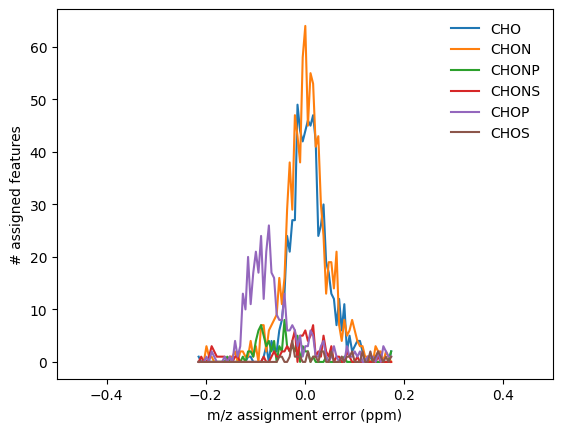

In [62]:
fresults2 = assignMolClass(results2)

pltMZerror(fresults2, bins=75)

plt.show()

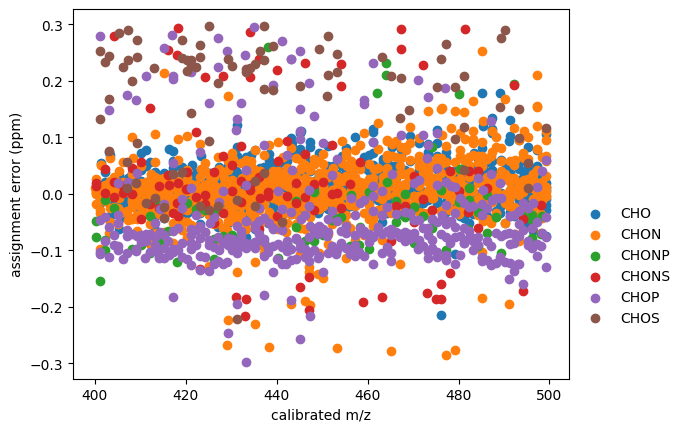

In [86]:
pltMZerror_pts(fresults2)

plt.show()

In [64]:
#trange = [12,14]
#interval = 4

qh2o_parser = getParser(qh2o)
qh2o_results = assign_formula(qh2o_parser,interval=interval,timerange=trange, refmasslist=refmasslist )

polarity: 1
MS Obj loaded - 624 peaks found.
MS Obj loaded - 624 peaks found.
Reference mass list loaded - 290 calibration masses loaded.
14 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.017 ppm
minimize function performed 609 fn evals and 8 iterations
'runworker'  5163.57 ms


Loading molecular formula database: 251938it [00:07, 34668.97it/s] 
Started molecular formula search for class {"N": 3, "S": 1, "P": 1, "O": 15}, (de)protonated : 100%|██████████| 300/300 [00:01<00:00, 178.58it/s]
Loading molecular formula database: 148382it [00:03, 37384.84it/s] 
Started molecular formula search for class {"N": 6, "S": 1, "P": 1, "O": 20}, (de)protonated : 100%|██████████| 260/260 [00:00<00:00, 387.75it/s]


'run_molecular_formula'  18808.63 ms
464 assigned peaks and 160 unassigned peaks, total  = 74.36 %, relative abundance = 75.57 %, RMS error (best candidate) (ppm) = 0.134


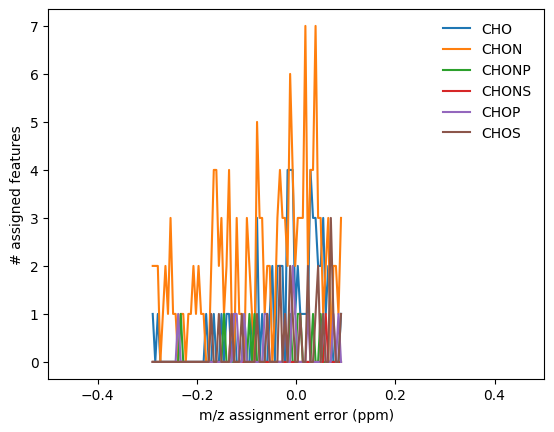

In [65]:
fresults3 = assignMolClass(qh2o_results)

pltMZerror(fresults3, bins=75)

plt.show()

In [66]:

## filter molform 
sub = filterMzRange(results1,[400,500])

blank_subtracted_n = results2[~results2['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]

blank_subtracted_full = sub[~sub['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]

overlap = blank_subtracted_n[blank_subtracted_n['Molecular Formula'].isin(blank_subtracted_full['Molecular Formula'])]

narrow_unique = blank_subtracted_n[~blank_subtracted_n['Molecular Formula'].isin(blank_subtracted_full['Molecular Formula'])]

full_range_bs = results1[~results1['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]


1420     23.562518
1422     35.013114
1428     15.291032
1430     78.704177
1434     29.417414
           ...    
3230      4.622257
3231      2.248334
3232      2.723361
3233      6.028251
3234    141.986700
Name: S/N Norm, Length: 1793, dtype: float64


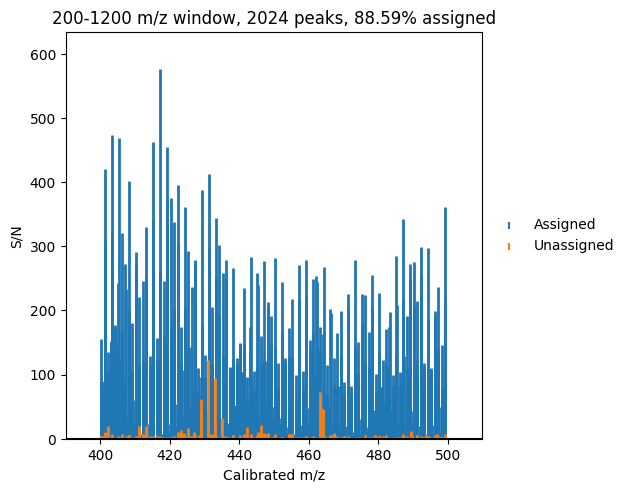

In [67]:


sn_lim = 20
df2=narrow_unique[narrow_unique['S/N']<sn_lim]

df1=blank_subtracted_full[blank_subtracted_full['S/N']<sn_lim]
df2=narrow_unique[narrow_unique['S/N']<sn_lim]
df3=overlap[overlap['S/N']<sn_lim]


df2a = sub[sub['Molecular Formula'].notna()]
df2b = sub[sub['Molecular Formula'].isna()]

n_mzs = np.shape(sub)[0]

per_a = np.shape(df2a)[0]  / (np.shape(df2a)[0] + np.shape(df2b)[0]) *100
per_b = np.shape(df2b)[0]  / (np.shape(df2a)[0] + np.shape(df2b)[0]) *100

plot_ms(df2a,df2=df2b, start_mz=400,end_mz = 500, tstart = 16, lbls=['Assigned', 'Unassigned'],labs=False) 

plt.title('200-1200 m/z window, %s peaks, %.2f%% assigned' %(n_mzs, per_a))
plt.show()






0        6.616467
1        2.145134
2       12.600368
3       46.145213
4        8.454899
          ...    
2567     4.603883
2568     3.978317
2569     2.014671
2570     4.829123
2571    91.211262
Name: S/N Norm, Length: 2572, dtype: float64


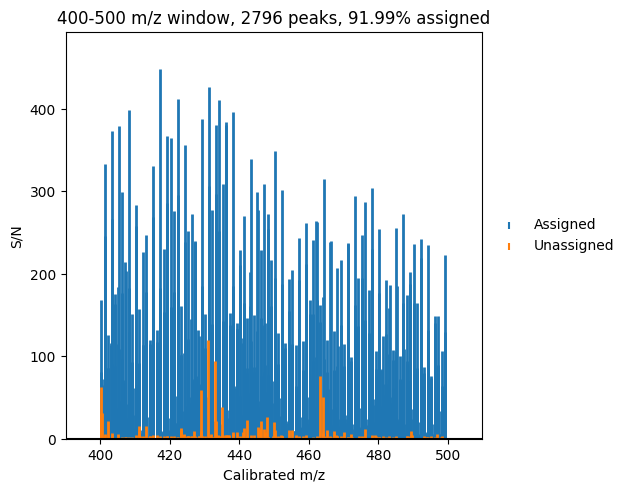

In [68]:


df2a = results2[results2['Molecular Formula'].notna()]
df2b = results2[results2['Molecular Formula'].isna()]

n_mzs = np.shape(results2)[0]

per_a = np.shape(df2a)[0]  / (np.shape(df2a)[0] + np.shape(df2b)[0]) *100
per_b = np.shape(df2b)[0]  / (np.shape(df2a)[0] + np.shape(df2b)[0]) *100

plot_ms(df2a,df2=df2b, start_mz=400,end_mz = 500, tstart = 16, lbls=['Assigned', 'Unassigned' ],labs=False) 

plt.title('400-500 m/z window, %s peaks, %.2f%% assigned' %(n_mzs, per_a))
plt.show()

0        6.616467
1        2.145134
2       12.600368
3       46.145213
4        8.454899
          ...    
2791     2.792120
2792     2.022584
2793     5.222573
2794     2.141387
2795     2.737219
Name: S/N Norm, Length: 2796, dtype: float64


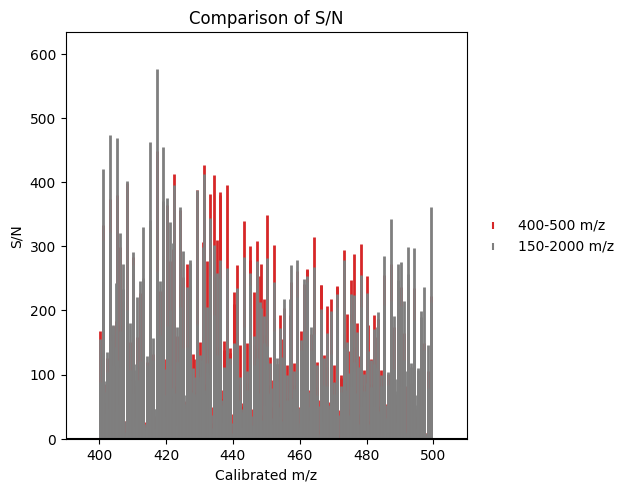

In [69]:

df2a = results2 #[results2['Molecular Formula'].notna()]
df2b = sub #[sub['Molecular Formula'].notna()]

n_mzs = np.shape(results2)[0]

per_a = np.shape(df2a)[0]  / (np.shape(df2a)[0] + np.shape(df2b)[0]) *100
per_b = np.shape(df2b)[0]  / (np.shape(df2a)[0] + np.shape(df2b)[0]) *100

plot_ms(df2a,df2=df2b, start_mz=400,end_mz = 500, tstart = 16, lbls=['400-500 m/z', '150-2000 m/z' ],labs=False, colors=['C3','C7']) 

plt.title('Comparison of S/N')
plt.show()

0        6.616467
2       12.600368
3       46.145213
5        6.847481
7       60.350644
          ...    
2567     4.603883
2568     3.978317
2569     2.014671
2570     4.829123
2571    91.211262
Name: S/N Norm, Length: 1536, dtype: float64


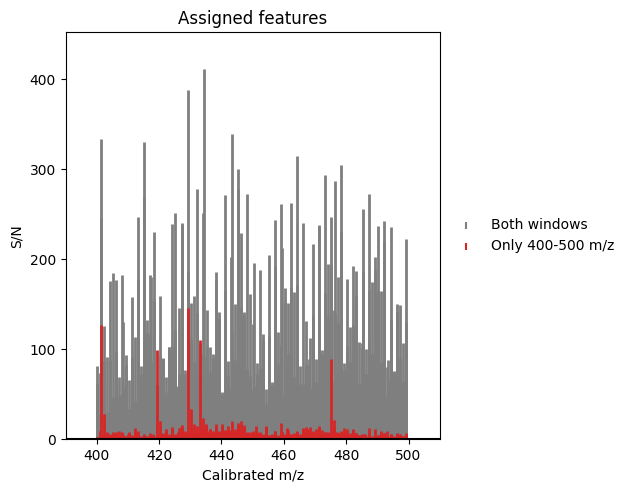

In [70]:
blank_subtracted_n = results2[~results2['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]

blank_subtracted_full = sub[~sub['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]

overlap = blank_subtracted_n[blank_subtracted_n['Molecular Formula'].isin(blank_subtracted_full['Molecular Formula'])]

narrow_unique = blank_subtracted_n[~blank_subtracted_n['Molecular Formula'].isin(blank_subtracted_full['Molecular Formula'])]

full_range_bs = results1[~results1['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]



df2a = overlap #[results2['Molecular Formula'].notna()]
df2b = narrow_unique #[sub['Molecular Formula'].notna()]

n_mzs = np.shape(results2)[0]

per_a = np.shape(df2a)[0]  / (np.shape(df2a)[0] + np.shape(df2b)[0]) *100
per_b = np.shape(df2b)[0]  / (np.shape(df2a)[0] + np.shape(df2b)[0]) *100

plot_ms(df2a,df2=df2b, start_mz=400,end_mz = 500, tstart = 16, lbls=['Both windows', 'Only 400-500 m/z' ],labs=False,colors=['C7','C3']) 

plt.title('Assigned features')
plt.show()

1372    29.131751
1376    83.971270
1382    49.244224
1387    34.967778
1389    28.456713
1392    38.324958
1394     9.996288
1395    59.036024
1397    56.757393
1403    28.806146
1405    13.144238
1407    71.633946
1413    27.240863
Name: S/N Norm, dtype: float64


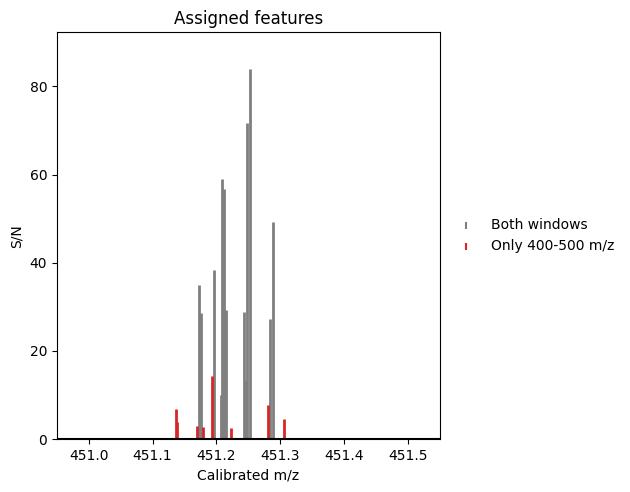

In [99]:
blank_subtracted_n = results2[~results2['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]

blank_subtracted_full = sub[~sub['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]

overlap = blank_subtracted_n[blank_subtracted_n['Molecular Formula'].isin(blank_subtracted_full['Molecular Formula'])]

narrow_unique = blank_subtracted_n[~blank_subtracted_n['Molecular Formula'].isin(blank_subtracted_full['Molecular Formula'])]

full_range_bs = results1[~results1['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]



df2a = overlap#[overlap['S'] > 0]
df2b = narrow_unique#[narrow_unique['S'] > 0] #[sub['Molecular Formula'].notna()]



plot_ms(df2a,df2=df2b, start_mz=451,end_mz = 451.5, tstart = 16, lbls=['Both windows', 'Only 400-500 m/z' ],labs=False,colors=['C7','C3']) 

plt.title('Assigned features')
plt.show()

6       10.581494
8       17.853796
10      32.713233
20      56.958320
27      86.062338
          ...    
1782     8.626050
1784    11.858017
1786    26.785009
1788     7.577458
1791    15.018219
Name: S/N Norm, Length: 316, dtype: float64


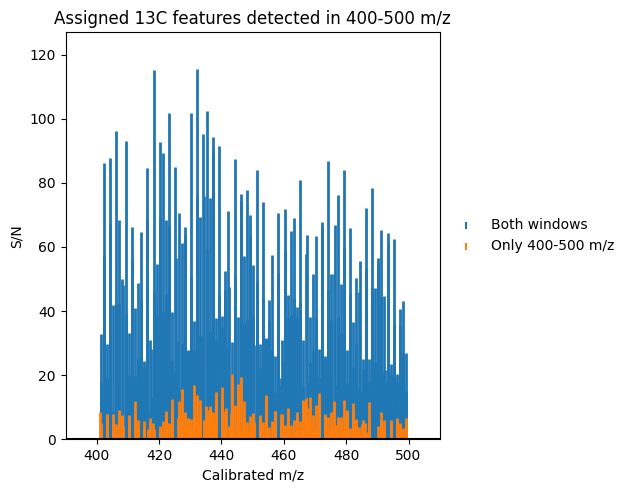

In [17]:
blank_subtracted_n = results2[~results2['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]

blank_subtracted_full = sub[~sub['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]

overlap = blank_subtracted_n[blank_subtracted_n['Molecular Formula'].isin(blank_subtracted_full['Molecular Formula'])]

narrow_unique = blank_subtracted_n[~blank_subtracted_n['Molecular Formula'].isin(blank_subtracted_full['Molecular Formula'])]

full_range_bs = results1[~results1['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]



df2a = overlap[overlap['13C'] > 0]
df2b = narrow_unique[narrow_unique['13C'] > 0] #[sub['Molecular Formula'].notna()]



plot_ms(df2a,df2=df2b, start_mz=400,end_mz = 500, tstart = 16, lbls=['Both windows', 'Only 400-500 m/z' ],labs=False) 

plt.title('Assigned 13C features detected in 400-500 m/z')
plt.show()

(198, 28)
358    8.600747
373    7.841299
376    4.841465
378    4.880732
Name: S/N Norm, dtype: float64


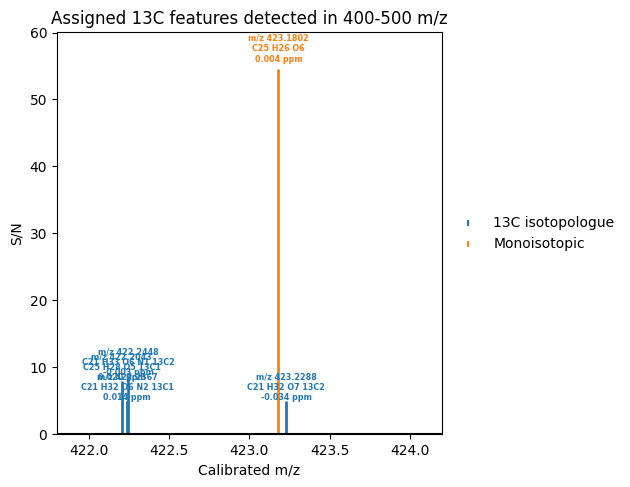

In [18]:
blank_subtracted_n = results2[~results2['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]

blank_subtracted_full = sub[~sub['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]

overlap = blank_subtracted_n[blank_subtracted_n['Molecular Formula'].isin(blank_subtracted_full['Molecular Formula'])]

narrow_unique = blank_subtracted_n[~blank_subtracted_n['Molecular Formula'].isin(blank_subtracted_full['Molecular Formula'])]

full_range_bs = results1[~results1['Molecular Formula'].isin(qh2o_results['Molecular Formula'])]



df2a = narrow_unique[narrow_unique['13C'] > 0] #[sub['Molecular Formula'].notna()]

df2b = blank_subtracted_n.loc[blank_subtracted_n['Index'].isin(df2a['Mono Isotopic Index'] )]
print(np.shape(df2b))

plot_ms(df2a, df2=df2b,start_mz=422,end_mz = 424, tstart = 16, lbls=[ '13C isotopologue', 'Monoisotopic' ],labs=True) 

plt.title('Assigned 13C features detected in 400-500 m/z')
plt.show()

In [ ]:
## van Krevelen plots 
## O/C, H/C
fig, ax = plt.subplots()
p1 =ax.scatter(x=results['O/C'],y=results['H/C'],s=results['Peak Height']/4000,c=results['Time'],cmap='viridis')
ax.set(xlabel='O/C',ylabel='H/C')
ax.legend(frameon=False)
fig.colorbar(p1,ax=[ax],label='Time')
plt.show()

In [ ]:

## O/C, N/C
fig, ax = plt.subplots()
p1 = ax.scatter(x=results['O/C'],y=results['N/C'],s=results['Peak Height']/4000,c=results['Time'],cmap='viridis')
ax.set(xlabel='O/C',ylabel='N/C')
fig.colorbar(p1,ax=[ax],label='Time')
plt.show()